# Making Transformers Efficient in Production

### Loading Libraries

In [40]:
# Numerical Computing 
import numpy as np

# Data Management
import pandas as pd

# Transformers
from transformers import Trainer
from transformers import pipeline
from transformers import AutoConfig
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers.convert_graph_to_onnx import convert
from transformers import AutoModelForSequenceClassification

# SciPy
from scipy.special import softmax

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import quantize_per_tensor
from torch.nn.quantized import QFunctional
from torch.quantization import quantize_dynamic

# Path Set-up
from pathlib import Path

# Datasets
from datasets import load_metric 
from datasets import load_dataset

# Data Visualization
import matplotlib.pyplot as plt

# Time & OS
import os
import sys
from time import perf_counter
from psutil import cpu_count

# from psutil import cpu_count

# Hyperparamter Tuning
import optuna 

# Toolkits
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
from onnxruntime import (GraphOptimizationLevel, InferenceSession, SessionOptions)
from onnxruntime.quantization import quantize_dynamic, QuantType

### Loading Data

In [2]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks

from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (526/526), done.
remote: Compressing objects: 100% (289/289), done.
remote: Total 526 (delta 251), reused 480 (delta 231), pack-reused 0
Receiving objects: 100% (526/526), 29.30 MiB | 27.50 MiB/s, done.
Resolving deltas: 100% (251/251), done.
/Users/isisromero/Desktop/NLP_transformer/chap_08/notebooks
⏳ Installing base requirements ...


/Users/isisromero/anaconda3/envs/NLP_transformer/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [3]:
from utils import *

setup_chapter()

No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Using transformers v4.39.3
Using datasets v2.19.0


### Intent Detection as a Case Study

In [4]:
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"

pipe = pipeline("text-classification", model=bert_ckpt)

In [5]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""

pipe(query)

[{'label': 'car_rental', 'score': 0.5490033626556396}]

### Creating a Performance Benchmark

In [6]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # We'll define this later
        pass    

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [7]:
# Retrieving & loading 'clinc' data
clinc = load_dataset("clinc_oos", "plus")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [9]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [10]:
# Compute accuracy method() as follow:
accuracy_score = load_metric("accuracy")

/var/folders/dk/f9pbhbp52qxc0613mpbtx8lm0000gn/T/ipykernel_56687/1364396659.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")
/Users/isisromero/anaconda3/envs/NLP_transformer/lib/python3.11/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [11]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [12]:
# Model's saving
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [13]:
# To re-use later with Path.stat()
torch.save(pipe.model.state_dict(), "model.pt")

In [14]:
def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [15]:
# Model Performance Counter() - Average Latency per Query as follow:
for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 197.199
Latency (ms) - 53.758
Latency (ms) - 79.474


##### CPU warm-up for time run:

In [16]:
def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [17]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 59.83 +\- 56.26
Accuracy on test set - 0.867


## Making Models Smaller via Knowledge Distillation

### Creating a Knowledge Distillation Trainer

In [18]:
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [19]:
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Choosing a Good Student Initialization

In [20]:
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [21]:
from huggingface_hub import notebook_login

notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [32]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"

student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt,
    evaluation_strategy = "epoch", 
    num_train_epochs=5,
    learning_rate=2e-5, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,
    alpha=1,
    weight_decay=0.01, 
    push_to_hub=True)

In [33]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
student_training_args.log_level = 'error'

In [34]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [35]:
id2label = pipe.model.config.id2label

label2id = pipe.model.config.label2id

In [36]:
num_labels = intents.num_classes

student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels, 
                                   id2label=id2label, label2id=label2id))

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [38]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [39]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,4.304200,3.295900,0.724194
2,2.643400,1.886089,0.850323
3,1.570300,1.172028,0.890968
4,1.030500,0.876320,0.913871
5,0.810700,0.789781,0.917419


TrainOutput(global_step=1590, training_loss=2.0677690885351887, metrics={'train_runtime': 6703.6808, 'train_samples_per_second': 11.374, 'train_steps_per_second': 0.237, 'total_flos': 414689637990180.0, 'train_loss': 2.0677690885351887, 'epoch': 5.0})

In [41]:
distilbert_trainer.push_to_hub("Training completed!")

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/joacorf33/distilbert-base-uncased-finetuned-clinc/commit/122bc8e4bc239f0a7b528bcbd45dcb621d31ffa1', commit_message='Training completed!', commit_description='', oid='122bc8e4bc239f0a7b528bcbd45dcb621d31ffa1', pr_url=None, pr_revision=None, pr_num=None)

In [42]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [43]:
optim_type = "DistilBERT"

pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 73.39 +\- 36.15
Accuracy on test set - 0.858


/var/folders/dk/f9pbhbp52qxc0613mpbtx8lm0000gn/T/ipykernel_56687/3708761664.py:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


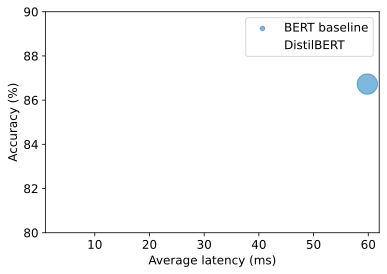

In [44]:
def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

### Finding Good Hyperparameters with Optuna

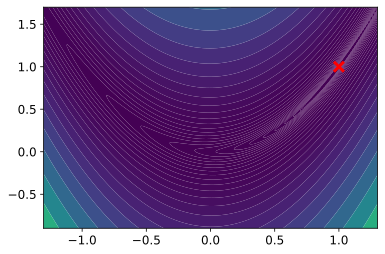

In [45]:
def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [46]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [47]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-05-01 17:24:12,781] A new study created in memory with name: no-name-2f6acebe-ea95-4402-bdc3-af46ede7673e
[I 2024-05-01 17:24:12,786] Trial 0 finished with value: 1.4909656311164134 and parameters: {'x': -0.009969657314814917, 'y': -0.06852472140417776}. Best is trial 0 with value: 1.4909656311164134.
[I 2024-05-01 17:24:12,788] Trial 1 finished with value: 1055.4497979190608 and parameters: {'x': 1.623801199437843, 'y': -0.6114394108576477}. Best is trial 0 with value: 1.4909656311164134.
[I 2024-05-01 17:24:12,789] Trial 2 finished with value: 161.06713761647833 and parameters: {'x': 0.1143518997912274, 'y': 1.27910465469123}. Best is trial 0 with value: 1.4909656311164134.
[I 2024-05-01 17:24:12,791] Trial 3 finished with value: 114.75673233061022 and parameters: {'x': 0.12452857098060077, 'y': 1.0831696810229365}. Best is trial 0 with value: 1.4909656311164134.
[I 2024-05-01 17:24:12,792] Trial 4 finished with value: 8.643790239057342 and parameters: {'x': 1.149281336713367

[I 2024-05-01 17:24:12,917] Trial 42 finished with value: 72.95704357726355 and parameters: {'x': 1.5329836469316271, 'y': 1.497554421964161}. Best is trial 38 with value: 0.10228149494972176.
[I 2024-05-01 17:24:12,920] Trial 43 finished with value: 37.627375419878604 and parameters: {'x': 1.0460497928142025, 'y': 0.4808258844591419}. Best is trial 38 with value: 0.10228149494972176.
[I 2024-05-01 17:24:12,923] Trial 44 finished with value: 23.980571645976863 and parameters: {'x': 0.5706165693542937, 'y': 0.8134167737032818}. Best is trial 38 with value: 0.10228149494972176.
[I 2024-05-01 17:24:12,926] Trial 45 finished with value: 51.59584462946377 and parameters: {'x': 1.3424914239809675, 'y': 1.0847977235813455}. Best is trial 38 with value: 0.10228149494972176.
[I 2024-05-01 17:24:12,930] Trial 46 finished with value: 757.744226234141 and parameters: {'x': 1.8493814162544189, 'y': 0.6688069316451235}. Best is trial 38 with value: 0.10228149494972176.
[I 2024-05-01 17:24:12,933] Tr

[I 2024-05-01 17:24:13,058] Trial 84 finished with value: 7.435154256851128 and parameters: {'x': -0.39095921755162166, 'y': -0.08167992278435081}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,062] Trial 85 finished with value: 22.899196107661503 and parameters: {'x': 0.0032630260428038182, 'y': -0.46802473072992623}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,065] Trial 86 finished with value: 33.03107366463739 and parameters: {'x': 0.8119933598658295, 'y': 0.08491414324610735}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,067] Trial 87 finished with value: 1059.2994628355018 and parameters: {'x': 1.2277511867193684, 'y': -1.7472354365635852}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,070] Trial 88 finished with value: 8.374569252585474 and parameters: {'x': -0.7420361373954769, 'y': 0.3195358395982057}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17

[I 2024-05-01 17:24:13,189] Trial 126 finished with value: 4.169988691311136 and parameters: {'x': 0.8020107839718859, 'y': 0.43997787307278236}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,192] Trial 127 finished with value: 61.04756895737326 and parameters: {'x': -0.003195006364130948, 'y': 0.7748725747901022}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,195] Trial 128 finished with value: 103.0002452796058 and parameters: {'x': -0.3170205249409353, 'y': 1.1068106250249115}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,198] Trial 129 finished with value: 135.4887950119781 and parameters: {'x': 1.051800457932625, 'y': -0.05770081259514196}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,201] Trial 130 finished with value: 3.8282982848314933 and parameters: {'x': 0.5114743235362361, 'y': 0.07214250567164684}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:

[I 2024-05-01 17:24:13,323] Trial 168 finished with value: 56.73605926743907 and parameters: {'x': 0.9579334307703883, 'y': 0.1644147794537683}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,327] Trial 169 finished with value: 1.0083857534901661 and parameters: {'x': 0.2156441545640136, 'y': -0.01620100052129205}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,330] Trial 170 finished with value: 92.61991053905925 and parameters: {'x': 0.25540515148986326, 'y': 1.0247394206144955}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,333] Trial 171 finished with value: 0.9530473722569913 and parameters: {'x': 0.04219847084362702, 'y': -0.017104098563113037}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,337] Trial 172 finished with value: 0.7777794879690976 and parameters: {'x': 0.20635284759392844, 'y': 0.0041232495120015755}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-

[I 2024-05-01 17:24:13,478] Trial 210 finished with value: 1.3462596054636533 and parameters: {'x': 0.8289175341664247, 'y': 0.5723440764903776}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,482] Trial 211 finished with value: 1.4787219960449265 and parameters: {'x': 0.715667805786633, 'y': 0.6304122651722932}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,486] Trial 212 finished with value: 0.8626386522606011 and parameters: {'x': 0.7730546091393208, 'y': 0.687676431205785}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,489] Trial 213 finished with value: 1.6256493500571667 and parameters: {'x': 0.6550722877343033, 'y': 0.5518663609049863}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:13,494] Trial 214 finished with value: 0.5396670960325362 and parameters: {'x': 0.7534026617304037, 'y': 0.49841608741024707}. Best is trial 59 with value: 0.09549830603855405.
[I 2024-05-01 17:24:1

[I 2024-05-01 17:24:13,653] Trial 252 finished with value: 8.46427465252565 and parameters: {'x': 1.0878520289176514, 'y': 0.8926204434006015}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:13,657] Trial 253 finished with value: 0.6026045592927526 and parameters: {'x': 0.8901905405169067, 'y': 0.7155921788413652}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:13,661] Trial 254 finished with value: 3.460973066944974 and parameters: {'x': 0.9841927325346804, 'y': 0.7826051437501439}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:13,666] Trial 255 finished with value: 1.6260503764944017 and parameters: {'x': 0.8212390932320504, 'y': 0.5481761766041509}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:13,670] Trial 256 finished with value: 3.426201651841322 and parameters: {'x': 0.903729741366059, 'y': 0.6318779474820748}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:

[I 2024-05-01 17:24:13,835] Trial 294 finished with value: 581.954362247422 and parameters: {'x': 1.7375117230258268, 'y': 0.6077015859855999}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:13,840] Trial 295 finished with value: 60.61515932067568 and parameters: {'x': 1.1468402746043713, 'y': 0.5368237227340728}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:13,845] Trial 296 finished with value: 2.2726589664002756 and parameters: {'x': 0.8038473279327204, 'y': 0.7956423666360343}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:13,849] Trial 297 finished with value: 5.500648797527762 and parameters: {'x': 0.9514252068587064, 'y': 0.670725611615222}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:13,853] Trial 298 finished with value: 2.454703973137865 and parameters: {'x': 0.8573386361709185, 'y': 0.5790054457134318}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:1

[I 2024-05-01 17:24:14,033] Trial 336 finished with value: 14.511382507838709 and parameters: {'x': 1.0024572881555573, 'y': 0.62398260820805}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:14,037] Trial 337 finished with value: 1.7458016149981277 and parameters: {'x': 0.594455595359615, 'y': 0.4791286119409992}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:14,042] Trial 338 finished with value: 161.68279828610173 and parameters: {'x': 1.4232348355055509, 'y': 0.7547564527390639}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:14,048] Trial 339 finished with value: 17.5848530792175 and parameters: {'x': 0.8063252860566748, 'y': 1.069055957294402}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:14,052] Trial 340 finished with value: 0.6696625159484355 and parameters: {'x': 0.7027322166860287, 'y': 0.5700752323402827}. Best is trial 250 with value: 0.03335558806618975.
[I 2024-05-01 17:24:1

[I 2024-05-01 17:24:14,234] Trial 378 finished with value: 0.553942837653168 and parameters: {'x': 0.8054110717165165, 'y': 0.7205255625419343}. Best is trial 365 with value: 0.018696827430128363.
[I 2024-05-01 17:24:14,239] Trial 379 finished with value: 0.114136250465222 and parameters: {'x': 0.8623112303444556, 'y': 0.7744315985109895}. Best is trial 365 with value: 0.018696827430128363.
[I 2024-05-01 17:24:14,244] Trial 380 finished with value: 0.12424405841040907 and parameters: {'x': 0.9813581135803073, 'y': 0.9278648069806966}. Best is trial 365 with value: 0.018696827430128363.
[I 2024-05-01 17:24:14,249] Trial 381 finished with value: 795.5599649821083 and parameters: {'x': 1.9474178408345568, 'y': 0.9734606094157979}. Best is trial 365 with value: 0.018696827430128363.
[I 2024-05-01 17:24:14,254] Trial 382 finished with value: 0.13959001154251294 and parameters: {'x': 0.9749273021378942, 'y': 0.9132057215527427}. Best is trial 365 with value: 0.018696827430128363.
[I 2024-05-

[I 2024-05-01 17:24:14,419] Trial 420 finished with value: 6.016186789234827 and parameters: {'x': 1.0837386734430239, 'y': 0.9293533333500503}. Best is trial 413 with value: 0.008399774631156222.
[I 2024-05-01 17:24:14,423] Trial 421 finished with value: 2.254100092056686 and parameters: {'x': 0.9417830632094452, 'y': 1.0369790322877053}. Best is trial 413 with value: 0.008399774631156222.
[I 2024-05-01 17:24:14,428] Trial 422 finished with value: 28.390281736033263 and parameters: {'x': 1.2218200467098446, 'y': 0.9604808393438764}. Best is trial 413 with value: 0.008399774631156222.
[I 2024-05-01 17:24:14,432] Trial 423 finished with value: 8.993168635948537 and parameters: {'x': 0.9288783942607708, 'y': 1.1626168450541376}. Best is trial 413 with value: 0.008399774631156222.
[I 2024-05-01 17:24:14,436] Trial 424 finished with value: 0.5419475820677019 and parameters: {'x': 1.139320306682228, 'y': 1.3703375120248178}. Best is trial 413 with value: 0.008399774631156222.
[I 2024-05-01 

[I 2024-05-01 17:24:14,597] Trial 462 finished with value: 37.218062553725225 and parameters: {'x': 1.286539259284297, 'y': 1.0457904711161004}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,601] Trial 463 finished with value: 758.0136163797265 and parameters: {'x': 0.9515931586791726, 'y': -1.8476709128419544}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,605] Trial 464 finished with value: 8.74108973313251 and parameters: {'x': 1.1158961751993943, 'y': 1.540650369654147}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,610] Trial 465 finished with value: 108.62084300716187 and parameters: {'x': 0.8455840042427847, 'y': 1.7571111457098194}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,614] Trial 466 finished with value: 4.441443083525573 and parameters: {'x': 1.0212584937176576, 'y': 0.8322323180605544}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05

[I 2024-05-01 17:24:14,780] Trial 504 finished with value: 22.57732006708316 and parameters: {'x': 1.1785785312838475, 'y': 0.9142270749789898}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,784] Trial 505 finished with value: 0.006251492243062146 and parameters: {'x': 0.9870319174303238, 'y': 0.9820315708073268}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,788] Trial 506 finished with value: 0.006386840230532471 and parameters: {'x': 0.9853370416154228, 'y': 0.9787451901370018}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,793] Trial 507 finished with value: 6.122922426802055 and parameters: {'x': 1.1072004965269817, 'y': 0.9786798637966296}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,797] Trial 508 finished with value: 0.021610246277413214 and parameters: {'x': 0.9921391698558618, 'y': 0.9990195239119506}. Best is trial 433 with value: 0.0006040838608042973.
[

[I 2024-05-01 17:24:14,970] Trial 546 finished with value: 33.269856018918745 and parameters: {'x': -1.3199481540127698, 'y': 1.2141751008090833}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,975] Trial 547 finished with value: 7.0653971682926215 and parameters: {'x': 1.1869187247497088, 'y': 1.1436259401980742}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,979] Trial 548 finished with value: 0.9390655692588292 and parameters: {'x': 1.0830329188750514, 'y': 1.0764112948976399}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,983] Trial 549 finished with value: 313.2696136497963 and parameters: {'x': 1.7353412899541567, 'y': 1.2429951684146785}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:14,988] Trial 550 finished with value: 0.06815928802550343 and parameters: {'x': 1.0440635556823739, 'y': 1.1158015066529465}. Best is trial 433 with value: 0.0006040838608042973.
[I 2

[I 2024-05-01 17:24:15,164] Trial 588 finished with value: 0.016026159066431598 and parameters: {'x': 0.980341639368448, 'y': 0.9735756116652846}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,169] Trial 589 finished with value: 13.70940007478295 and parameters: {'x': 1.148551515587976, 'y': 0.9492066327155422}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,174] Trial 590 finished with value: 3.5837355302106704 and parameters: {'x': 0.9729611704339685, 'y': 1.1359416963861064}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,178] Trial 591 finished with value: 0.3263356462050145 and parameters: {'x': 1.062964895422594, 'y': 1.0731166383940407}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,183] Trial 592 finished with value: 19.367480114592972 and parameters: {'x': 0.8821564815303944, 'y': 1.2181272452876752}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024

[I 2024-05-01 17:24:15,382] Trial 630 finished with value: 1.3045096039141564 and parameters: {'x': 1.0594114089358844, 'y': 1.0082920280189325}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,388] Trial 631 finished with value: 1.9922016703351586 and parameters: {'x': 0.9803148397513501, 'y': 0.8198855385217985}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,393] Trial 632 finished with value: 13.218946025473517 and parameters: {'x': 1.2346519074922266, 'y': 1.1615446537185452}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,398] Trial 633 finished with value: 2.0738645107757088 and parameters: {'x': 0.8990624396784319, 'y': 0.9519682780000354}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,403] Trial 634 finished with value: 0.16262489940727826 and parameters: {'x': 1.114672580468849, 'y': 1.2811569712574689}. Best is trial 433 with value: 0.0006040838608042973.
[I 20

[I 2024-05-01 17:24:15,613] Trial 672 finished with value: 7.460101105206457 and parameters: {'x': 0.9200774283229995, 'y': 1.119557372745839}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,618] Trial 673 finished with value: 687.6426482991948 and parameters: {'x': 1.1163052443309711, 'y': -1.37613093517299}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,625] Trial 674 finished with value: 0.14377743844045984 and parameters: {'x': 1.003683396483073, 'y': 1.0452965668093013}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,632] Trial 675 finished with value: 596.9635794713913 and parameters: {'x': 1.8265373015706534, 'y': 0.8943531449739708}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-05-01 17:24:15,638] Trial 676 finished with value: 0.14548242856305207 and parameters: {'x': 0.9752166186394275, 'y': 0.9891090103289718}. Best is trial 433 with value: 0.0006040838608042973.
[I 2024-0

[I 2024-05-01 17:24:15,869] Trial 714 finished with value: 10.663350565864055 and parameters: {'x': 1.0843171787333363, 'y': 0.849304757772062}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:15,875] Trial 715 finished with value: 0.5858841297912921 and parameters: {'x': 0.9449700487015187, 'y': 0.9693133884731999}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:15,881] Trial 716 finished with value: 0.0326594699724247 and parameters: {'x': 1.0217799339067548, 'y': 1.061974440816972}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:15,888] Trial 717 finished with value: 18.598128102888605 and parameters: {'x': 0.8567060787553168, 'y': 1.1649626478930935}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:15,895] Trial 718 finished with value: 20.451499353408153 and parameters: {'x': 1.1779868057353011, 'y': 0.9357699644828946}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024

[I 2024-05-01 17:24:16,110] Trial 756 finished with value: 24.204964593508702 and parameters: {'x': 0.8612236194400238, 'y': 1.2334957698854145}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,115] Trial 757 finished with value: 2.2539208519497396 and parameters: {'x': 1.018499709933611, 'y': 0.8872224194391296}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,120] Trial 758 finished with value: 576.275221801262 and parameters: {'x': 0.9390958202920037, 'y': -1.5186646246717324}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,126] Trial 759 finished with value: 0.1306009574619588 and parameters: {'x': 1.0769499294007228, 'y': 1.124511142530929}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,131] Trial 760 finished with value: 0.03820550069006487 and parameters: {'x': 1.0104896573762625, 'y': 1.001571287366766}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-

[I 2024-05-01 17:24:16,351] Trial 798 finished with value: 1.0474053157361776 and parameters: {'x': 0.9346645413307217, 'y': 0.9757318634682509}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,356] Trial 799 finished with value: 16.148907942831322 and parameters: {'x': 1.1156386445378745, 'y': 0.8429589623592257}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,363] Trial 800 finished with value: 12.528368526007231 and parameters: {'x': 1.1973828849464234, 'y': 1.0803222004198212}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,368] Trial 801 finished with value: 1.8360082576533048 and parameters: {'x': 1.0415241679387366, 'y': 0.9493368511380509}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,374] Trial 802 finished with value: 52.1928954774191 and parameters: {'x': 0.7996349971971604, 'y': 1.3615847333153608}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024

[I 2024-05-01 17:24:16,596] Trial 840 finished with value: 685.7948001459522 and parameters: {'x': -1.8288577716010737, 'y': 0.7412761769254486}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,601] Trial 841 finished with value: 9.481100485397999 and parameters: {'x': 0.8226980977989526, 'y': 0.9842352264839804}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,607] Trial 842 finished with value: 7.0601903308673375 and parameters: {'x': 0.9491896900653733, 'y': 1.166622669078038}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,613] Trial 843 finished with value: 13.001987479675435 and parameters: {'x': 1.1787891796765324, 'y': 1.029404763842185}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,618] Trial 844 finished with value: 1.6237666359488627 and parameters: {'x': 1.0635596056738283, 'y': 1.2584275231626634}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-

[I 2024-05-01 17:24:16,846] Trial 882 finished with value: 3.3512366359184855 and parameters: {'x': 0.999969736566094, 'y': 0.8168756426940079}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,852] Trial 883 finished with value: 5.301590104349624 and parameters: {'x': 0.869686668320347, 'y': 0.9862376655219534}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,859] Trial 884 finished with value: 0.0032410207795717703 and parameters: {'x': 0.943978036314869, 'y': 0.890081812133501}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,865] Trial 885 finished with value: 2.3985676907755002 and parameters: {'x': 0.7783822513446033, 'y': 0.7591581927848257}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:16,870] Trial 886 finished with value: 0.0654263853652768 and parameters: {'x': 0.8486392652005044, 'y': 0.6995691181287911}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024

[I 2024-05-01 17:24:17,102] Trial 924 finished with value: 2.551629010004833 and parameters: {'x': 0.9172643743207001, 'y': 0.6818501465148273}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:17,109] Trial 925 finished with value: 2.914666910251753 and parameters: {'x': 1.0066918722793072, 'y': 0.8427058813716666}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:17,115] Trial 926 finished with value: 580.9582785510682 and parameters: {'x': 0.852712817515967, 'y': -1.6831434610940432}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:17,122] Trial 927 finished with value: 2.775513246229011 and parameters: {'x': 1.0502889257679082, 'y': 0.9365840282455682}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-05-01 17:24:17,129] Trial 928 finished with value: 1.1760612168169156 and parameters: {'x': 0.9525907662374843, 'y': 0.7990864902093634}. Best is trial 689 with value: 0.0003131578259575798.
[I 2024-0

[I 2024-05-01 17:24:17,373] Trial 966 finished with value: 1.3468012922126926 and parameters: {'x': 1.1341146753192268, 'y': 1.1709418782311414}. Best is trial 944 with value: 0.00020775403005229132.
[I 2024-05-01 17:24:17,380] Trial 967 finished with value: 0.004817818341192827 and parameters: {'x': 0.9798788437754723, 'y': 0.9668055578972211}. Best is trial 944 with value: 0.00020775403005229132.
[I 2024-05-01 17:24:17,386] Trial 968 finished with value: 149.19407466229598 and parameters: {'x': -1.4530956449089234, 'y': 0.9149235557718727}. Best is trial 944 with value: 0.00020775403005229132.
[I 2024-05-01 17:24:17,393] Trial 969 finished with value: 5.597856185278489 and parameters: {'x': 0.7393969649176364, 'y': 0.7818661640217395}. Best is trial 944 with value: 0.00020775403005229132.
[I 2024-05-01 17:24:17,399] Trial 970 finished with value: 3.191995368858556 and parameters: {'x': 0.8877964104290856, 'y': 0.9664913479035175}. Best is trial 944 with value: 0.00020775403005229132.

In [48]:
study.best_params

{'x': 0.990330969536376, 'y': 0.9796864863808609}

In [49]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [51]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

In [52]:
print(best_run)

In [53]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

In [54]:
distil_trainer.push_to_hub("Training complete")

### Benchmarking Our Distilled Model

In [55]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"

pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

In [56]:
plot_metrics(perf_metrics, optim_type)

## Making Models Faster with Quantization

In [57]:
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]

plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.grid(True)
plt.show()

In [58]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [59]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

In [60]:
dtype = torch.qint8

quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

In [61]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# Create histogram
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# Create zoom inset
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [62]:
%%timeit 
weights @ weights

In [63]:
q_fn = QFunctional()

In [64]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

In [65]:
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

In [66]:
model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### Benchmarking Our Quantized Model

In [67]:
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

In [68]:
plot_metrics(perf_metrics, optim_type)

### Optimizing Inference with ONNX and the ONNX Runtime

In [69]:
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [70]:
model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

In [71]:
def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [72]:
onnx_model = create_model_for_provider(onnx_model_path)

In [73]:
inputs = clinc_enc["test"][:1]

del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

In [74]:
np.argmax(logits_onnx)

In [75]:
clinc_enc["test"][0]["labels"]

In [76]:
class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [77]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

In [78]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [79]:
optim_type = "Distillation + ORT"

pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

In [80]:
plot_metrics(perf_metrics, optim_type)

In [81]:
model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"

quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [82]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, 
                              model_path=model_out

In [83]:
plot_metrics(perf_metrics, optim_type)

### Making Models Sparser with Weight Pruning

#### Magnitude pruning

In [84]:
def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()